In [1]:
# train_tfidf_xgb.py

import re
import pickle
import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# download stopwords once
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# prepare the stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# load hoax news and filter to only true hoaxes
hoax = pd.read_csv(
    "../Dataset/hoax_news.csv",
    usecols=["Title", "Narasi", "category"]
).dropna(subset=["Title", "Narasi", "category"])
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])]
hoax = hoax.rename(columns={"Title": "title", "Narasi": "body"})
hoax["label"] = "hoax"

# load real news data
real = pd.read_csv(
    "../Dataset/detik_news.csv",
    usecols=["page", "title", "url", "content"]
).dropna(subset=["title", "content"])
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# remove outliers in hoax based on title/body length
for field in ("title", "body"):
    lengths = hoax[field].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lower) & (lengths <= upper)]
hoax = hoax.drop(columns=["category"])

# balance classes by down-sampling
df = pd.concat([hoax, real], ignore_index=True)
min_size = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(
    lambda grp: grp.sample(min_size, random_state=42)
)

# split into train, validation, and test sets (70/20/10)
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# function to clean, tokenize, and stem text
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# apply preprocessing to each split
for subset in (X_train, X_val, X_test):
    subset["text"] = (
        subset["title"].apply(clean_tokenize).apply(" ".join)
        + " "
        + subset["body"].apply(clean_tokenize).apply(" ".join)
    )

# convert text to TF-IDF features limited to 1000 tokens
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(X_train["text"])
X_val_tfidf   = vectorizer.transform(X_val["text"])
X_test_tfidf  = vectorizer.transform(X_test["text"])

# perform feature masking augmentation on training data
mask_prob = 0.40
rng = np.random.default_rng(42)
base_array = X_train_tfidf.toarray()
mask = rng.binomial(1, 1 - mask_prob, size=base_array.shape)
augmented_array = base_array * mask

X_train_final = np.vstack([base_array, augmented_array])
y_train_final = np.hstack([y_train.values, y_train.values])

# encode labels to numeric
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train_final)
y_val_enc   = le.transform(y_val)
y_test_enc  = le.transform(y_test)

# train the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_final, y_train_enc)

# evaluate on validation set
val_preds = xgb_model.predict(X_val_tfidf.toarray())
print("Validation Accuracy:", accuracy_score(y_val_enc, val_preds))
print(classification_report(y_val_enc, val_preds, target_names=le.classes_))
print("Validation Confusion Matrix:")
print(confusion_matrix(y_val_enc, val_preds))

# evaluate on test set
test_preds = xgb_model.predict(X_test_tfidf.toarray())
print("Test Accuracy:", accuracy_score(y_test_enc, test_preds))
print(classification_report(y_test_enc, test_preds, target_names=le.classes_))
print("Test Confusion Matrix:")
print(confusion_matrix(y_test_enc, test_preds))

# save the pipeline including the label encoder
with open("tfidf_xgb_aug_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":         xgb_model,
        "vectorizer":    vectorizer,
        "stopwords":     stops,
        "mask_prob":     mask_prob,
        "stemmer":       stemmer,
        "label_encoder": le
    }, f)

print("Saved TF-IDF + XGBoost pipeline to tfidf_xgb_aug_hoax.pkl")


d:\Anaconda\envs\nlp\lib\site-packages\xgboost\core.py:158: UserWarning: [11:14:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Accuracy: 0.9937467430953622
              precision    recall  f1-score   support

        hoax       1.00      0.99      0.99       959
        real       0.99      1.00      0.99       960

    accuracy                           0.99      1919
   macro avg       0.99      0.99      0.99      1919
weighted avg       0.99      0.99      0.99      1919

Validation Confusion Matrix:
[[951   8]
 [  4 956]]
Test Accuracy: 0.9937434827945777
              precision    recall  f1-score   support

        hoax       1.00      0.99      0.99       480
        real       0.99      1.00      0.99       479

    accuracy                           0.99       959
   macro avg       0.99      0.99      0.99       959
weighted avg       0.99      0.99      0.99       959

Test Confusion Matrix:
[[476   4]
 [  2 477]]
Saved TF-IDF + XGBoost pipeline to tfidf_xgb_aug_hoax.pkl


OOD Results for TF-IDF + XGBoost
Accuracy: 0.5333333333333333
              precision    recall  f1-score   support

        hoax      0.533     1.000     0.696        80
        real      0.000     0.000     0.000        70

    accuracy                          0.533       150
   macro avg      0.267     0.500     0.348       150
weighted avg      0.284     0.533     0.371       150



d:\Anaconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda\envs\nlp\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


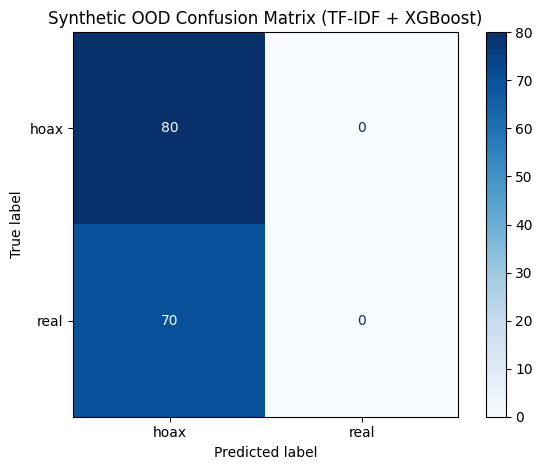

In [4]:
# test_tfidf_xgb_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# load the saved TF-IDF + XGBoost pipeline
with open("tfidf_xgb_aug_hoax.pkl", "rb") as f:
    data            = pickle.load(f)
    xgb_model       = data["model"]
    vectorizer      = data["vectorizer"]
    stops           = data["stopwords"]
    stemmer         = data["stemmer"]
    label_encoder   = data["label_encoder"]

# define cleaning and tokenization matching training
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# read the synthetic OOD dataset
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# preprocess and combine title and body
texts = [
    " ".join(clean_tokenize(t) + clean_tokenize(b))
    for t, b in zip(titles, bodies)
]

# convert to TF-IDF features
X_syn = vectorizer.transform(texts).toarray()

# predict numeric labels and convert back to strings
preds_numeric = xgb_model.predict(X_syn)
preds = label_encoder.inverse_transform(preds_numeric)

# print accuracy and classification report
print("OOD Results for TF-IDF + XGBoost")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

# display the confusion matrix
cm = confusion_matrix(true_labels, preds, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (TF-IDF + XGBoost)")
plt.tight_layout()
plt.show()
